In [2]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_snr_sme_results(epochs):
    # Define the time window in seconds
    # tmin, tmax = 0.1, 0.3
    tmin, tmax = 0, 1
    epsilon = 1e-10

    # We will calculate SNR, SME for each unique event in the concatenated epochs
    event_ids = epochs.event_id
    snr_results = {}
    sme_results = {}
    event_occurences = {}

    for event_id, _ in event_ids.items():
        # Select epochs for the current event_id
        epochs_specific = epochs[event_id]

        if len(epochs_specific) == 0:
            event_occurences[event_id] = 0
            continue
        
        # Get data and times, restrict to the time window of interest
        data = epochs_specific.get_data(picks='eeg')  # shape: (n_epochs, n_channels, n_times)
        times = epochs_specific.times
        time_window_mask = (times >= tmin) & (times <= tmax)
        
        # Extract the data within the specified time window
        data_in_window = data[:, :, time_window_mask]
        
        # Calculate the average ERP waveform (signal) across epochs for each time point and channel
        signal = data_in_window.mean(axis=0)
        
        # Calculate the standard deviation across epochs for each channel
        sd = np.std(data_in_window, axis=0)
        
        # Calculate N (the number of epochs for the current event_id)
        N = len(epochs_specific)
        
        # Calculate the Simple Measurement Error (SME) for each channel
        SME = sd / np.sqrt(N)
        
        # Calculate SNR for each channel at each timepoint
        SNR = np.abs(signal) / (SME + epsilon) # shape (n_channels, n_times)
        
        # Store the results
        snr_results[event_id] = SNR
        sme_results[event_id] = SME
        event_occurences[event_id] = N

    return snr_results, sme_results, event_occurences

In [4]:
# Path to the directory containing .fif files
fif_dir = os.path.join('..', 'eeg_data', 'final_eeg', '05_125')

# List all .fif files in the directory
fif_files = [f for f in os.listdir(fif_dir) if f.endswith('.fif')]

# Initialize an empty list to hold epochs from all files
all_epochs = []

for fif_file in fif_files:
    processed_fif_path = os.path.join(fif_dir, fif_file)
    epochs = mne.read_epochs(processed_fif_path, preload=True)
    all_epochs.append(epochs)

# Concatenate epochs from all files
concatenated_epochs = mne.concatenate_epochs(all_epochs)

# Calculate SNR and SME for each event in the concatenated epochs
snr_results, sme_results, event_occurences = get_snr_sme_results(concatenated_epochs)

Reading /Users/charles/Developer/all-joined/alljoined_preprocessing/snr/../eeg_data/final_eeg/05_125/subj05_session2_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3072 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/charles/Developer/all-joined/alljoined_preprocessing/snr/../eeg_data/final_eeg/05_125/subj04_session1_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3752 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/charles/Developer/all-joined/alljoined_preprocessing/snr/../eeg_data/final_eeg/05_125/subj01_session2_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3072 matching event

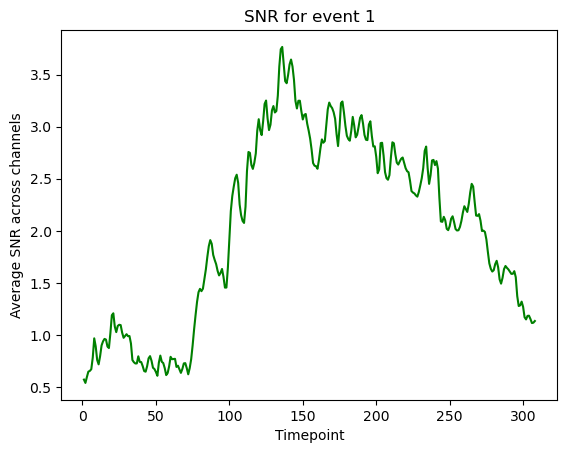

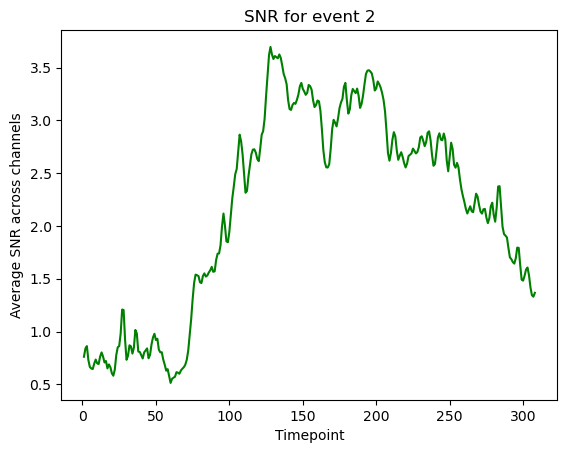

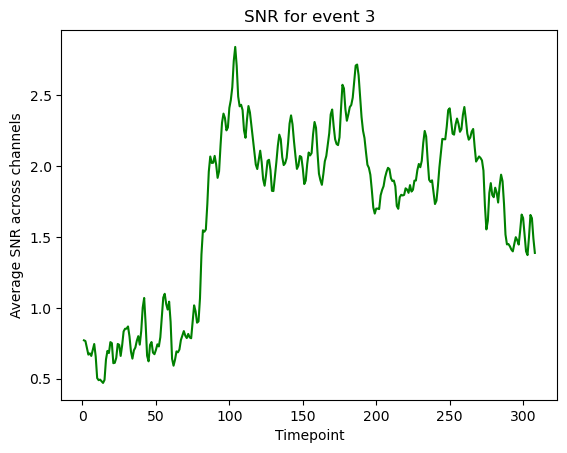

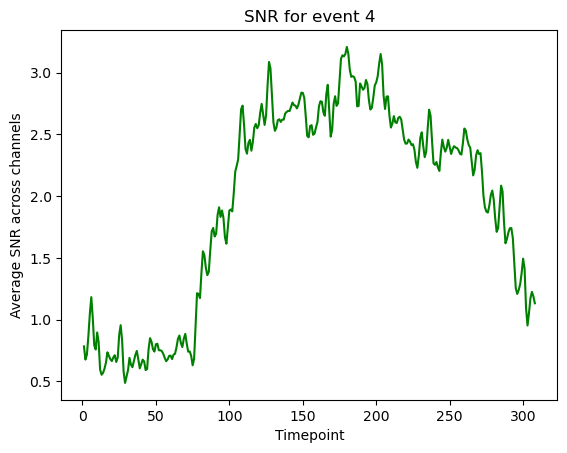

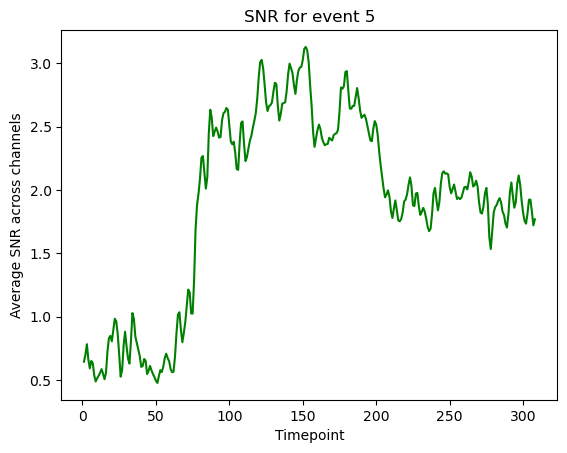

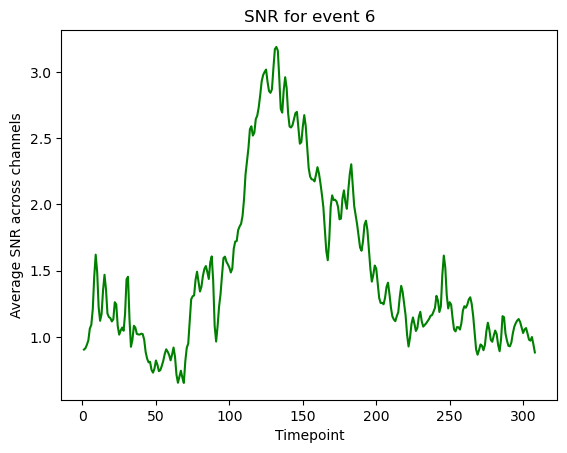

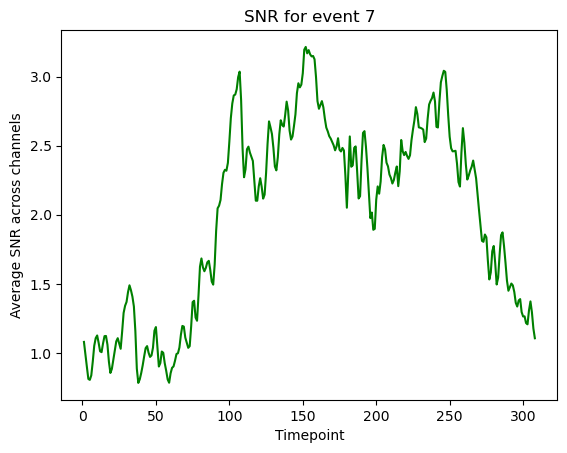

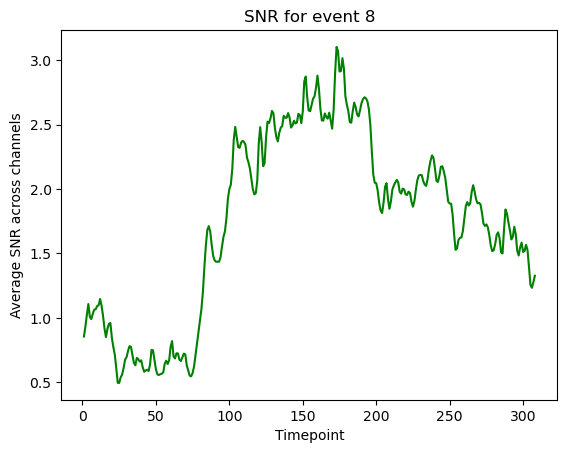

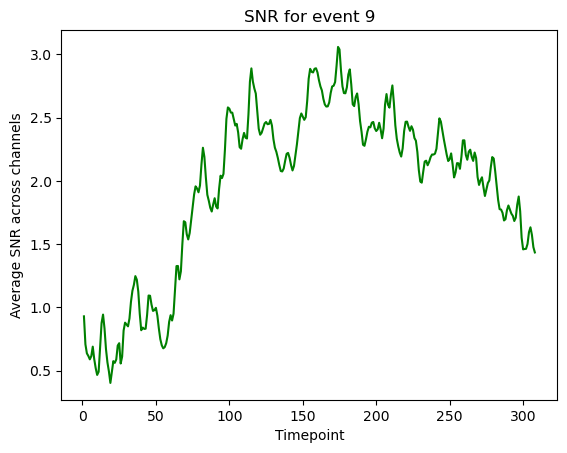

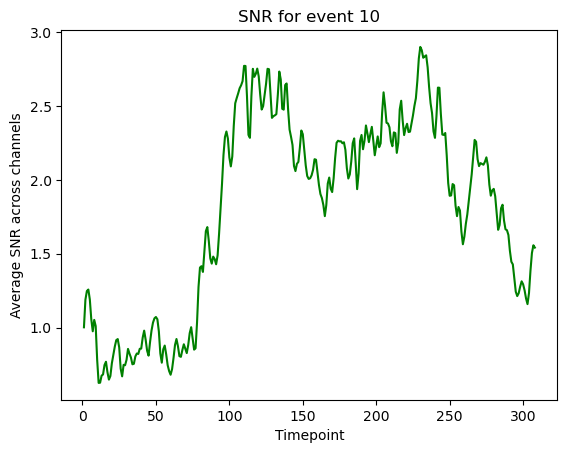

In [5]:
# Plot the SNR for across each timepoint for events 1-10
counter = 0
for event_id, snr in snr_results.items():
    counter += 1
    if counter > 10:
        break

    average_snr_per_timepoint = list(snr.mean(axis=0))
    timepoints = [i+1 for i in range(len(average_snr_per_timepoint))] 

    plt.figure()
    plt.plot(timepoints, average_snr_per_timepoint, color='green')
    plt.xlabel('Timepoint')
    plt.ylabel('Average SNR across channels')
    plt.title(f'SNR for event {event_id}')
    plt.show()

Event Occurences: {'1': 40, '2': 41, '3': 37, '4': 40, '5': 39, '6': 34, '7': 36, '8': 39, '9': 39, '10': 39, '11': 37, '12': 40, '13': 42, '14': 42, '15': 38, '16': 44, '17': 39, '18': 38, '19': 37, '20': 34, '21': 36, '22': 38, '23': 37, '24': 35, '25': 39, '26': 31, '27': 40, '28': 37, '29': 39, '30': 41, '31': 43, '32': 40, '33': 38, '34': 37, '35': 38, '36': 38, '37': 33, '38': 40, '39': 37, '40': 39, '41': 41, '42': 37, '43': 37, '44': 39, '45': 37, '46': 39, '47': 35, '48': 41, '49': 34, '50': 38, '51': 40, '52': 32, '53': 40, '54': 38, '55': 39, '56': 35, '57': 38, '58': 34, '59': 38, '60': 39, '61': 39, '62': 39, '63': 41, '64': 39, '65': 41, '66': 41, '67': 38, '68': 37, '69': 38, '70': 33, '71': 37, '72': 40, '73': 39, '74': 37, '75': 39, '76': 39, '77': 37, '78': 36, '79': 39, '80': 32, '81': 42, '82': 36, '83': 34, '84': 42, '85': 36, '86': 35, '87': 39, '88': 36, '89': 43, '90': 41, '91': 38, '92': 39, '93': 38, '94': 36, '95': 39, '96': 33, '97': 39, '98': 35, '99': 36, 

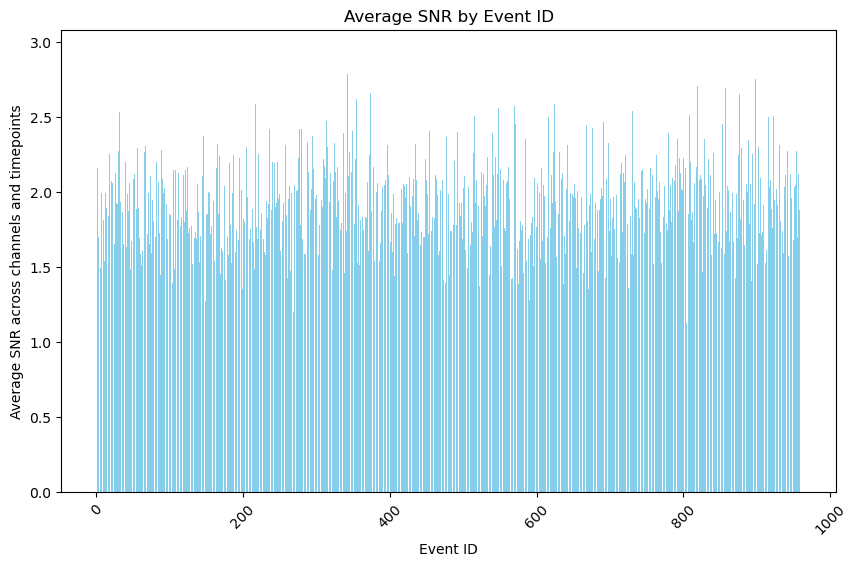

In [10]:

# Optionally, print the SME for each event_id (and each channel, if you wish)
# for event_id, SME in sme_results.items():
#     print(f"Event ID: {event_id}")
#     for i, sme_value in enumerate(SME):
#         print(f"  Channel {i+1}: SME = {sme_value}")

# Plotting SNR for a representative channel or average over channels, if preferred
# For simplicity, let's plot the average SNR across channels for each event ID
average_snr_per_event = {event_id: np.mean(SNR) for event_id, SNR in snr_results.items()}
events = list(average_snr_per_event.keys())
average_snr_values = list(average_snr_per_event.values())
print("Event Occurences:", event_occurences)

# Get the top 10 events with the highest average SNR
sorted_events = [[event_id, x, event_occurences] for event_id, x, event_occurences in sorted(zip(average_snr_values, events, event_occurences.values()), reverse=True)]
print("Top 10 events with the highest average SNR:", sorted_events[:10])

plt.figure(figsize=(10, 6))
plt.bar(list(map(lambda event: int(event), events)), average_snr_values, color='skyblue')
plt.xlabel('Event ID')
plt.ylabel('Average SNR across channels and timepoints')
plt.title('Average SNR by Event ID')
plt.xticks(rotation=45)
plt.show()


In [26]:
# Path to the directory containing .fif files
fif_dir = os.path.join('..', 'eeg_data', 'final_eeg', '05_125')

# List all .fif files in the directory
fif_files = [f for f in os.listdir(fif_dir) if f.endswith('.fif')]

# Getting average SNR for each subject, averaged across all event IDs and channels
session_epochs = {}

for fif_file in fif_files:
    session_id = (' ').join(fif_file.split('_')[0:2])
    processed_fif_path = os.path.join(fif_dir, fif_file)
    epochs = mne.read_epochs(processed_fif_path, preload=True)
    session_epochs[session_id] = epochs

Reading /Users/charles/Developer/all-joined/alljoined_preprocessing/snr/../eeg_data/final_eeg/05_125/subj05_session2_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3072 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/charles/Developer/all-joined/alljoined_preprocessing/snr/../eeg_data/final_eeg/05_125/subj04_session1_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3752 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/charles/Developer/all-joined/alljoined_preprocessing/snr/../eeg_data/final_eeg/05_125/subj01_session2_epo.fif ...
    Found the data of interest:
        t =     -50.78 ...     599.61 ms
        0 CTF compensation matrices available
Not setting metadata
3072 matching event

In [27]:
# Calculate SNR and SME for each event in the concatenated epochs
average_snr_per_session = {}

for session_id, epochs in session_epochs.items():
    print(f"Beginning calculations on {session_id}")
    snr_results, sme_results, event_occurences = get_snr_sme_results(epochs)
    print(f"Event Occurences: {event_occurences}")
    for event_id, event_occurences in event_occurences.items():
        if event_occurences == 0:
            print(f"Event ID {event_id} has 0 occurences")
    average_snr_per_event = {event_id: np.mean(SNR) for event_id, SNR in snr_results.items()}

    # Remove events with above average SNR
    removed_events = []
    for event_id, average_snr in average_snr_per_event.items():
        if average_snr > 150:
            print(f"Dropping event ID {event_id}, which has above average SNR of {average_snr}")
            removed_events.append(event_id)
    for event_id in removed_events:
        del average_snr_per_event[event_id]

    average_snr_values = list(average_snr_per_event.values())
    print(f"SNR values: {average_snr_values}")
    print(f"Session ID: {session_id}, Average SNR: {np.mean(average_snr_values)}")
    average_snr_per_session[session_id] = average_snr_values

# Printings the average SNR for each session
print("\nAverage SNR per session:")
for session_id, average_snr_values in average_snr_per_session.items():
    print(f"Session ID: {session_id}, Average SNR: {np.mean(average_snr_values)}")

Beginning calculations on subj05 session2
Event Occurences: {'1': 2, '2': 4, '3': 2, '4': 2, '5': 3, '6': 1, '7': 1, '8': 3, '9': 3, '10': 4, '11': 3, '12': 3, '13': 4, '14': 3, '15': 2, '16': 3, '17': 3, '18': 3, '19': 4, '20': 1, '21': 3, '22': 3, '23': 3, '24': 3, '25': 4, '26': 3, '27': 4, '28': 3, '29': 3, '30': 2, '31': 4, '32': 3, '33': 3, '34': 3, '35': 4, '36': 3, '37': 3, '38': 4, '39': 3, '40': 2, '41': 3, '42': 3, '43': 3, '44': 4, '45': 3, '46': 3, '47': 2, '48': 3, '49': 2, '50': 2, '51': 2, '52': 4, '53': 2, '54': 4, '55': 3, '56': 2, '57': 4, '58': 2, '59': 4, '60': 2, '61': 3, '62': 3, '63': 4, '64': 2, '65': 4, '66': 3, '67': 2, '68': 4, '69': 3, '70': 4, '71': 2, '72': 2, '73': 3, '74': 3, '75': 4, '76': 3, '77': 4, '78': 4, '79': 1, '80': 2, '81': 4, '82': 4, '83': 3, '84': 4, '85': 3, '86': 2, '87': 2, '88': 3, '89': 3, '90': 3, '91': 2, '92': 3, '93': 2, '94': 2, '95': 3, '96': 3, '97': 3, '98': 4, '99': 2, '100': 4, '101': 4, '102': 3, '103': 4, '104': 4, '105': 